In [1]:
!pip install libcirkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.8/156.8 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 MB 44.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 74.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 96.5 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 57.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta

In [1]:
import random
import numpy as np
import torch

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

device = torch.device('cuda')

Shape of the image to compress: torch.Size([3, 720, 1280])


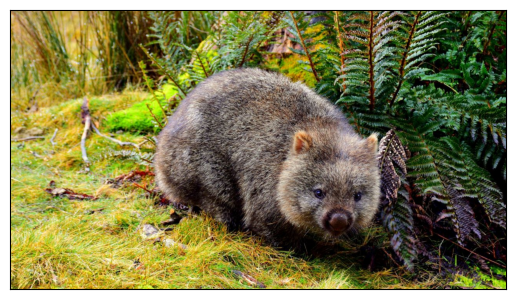

In [3]:
from torchvision import io
import matplotlib.pyplot as plt

!wget -q "https://www.pbs.org/wnet/nature/files/2021/06/meg-jerrard-mnHs4boXT_0-unsplash-scaled-e1623262400134-1280x720.jpg" -O "./wombat.jpg"

original_image = io.read_image("./wombat.jpg") / 255.0
print(f"Shape of the image to compress: {original_image.shape}")

plt.imshow(original_image.permute(1, 2, 0).cpu().numpy())
plt.xticks([], []); plt.yticks([], [])
plt.show()

In [4]:
import numpy as np
from cirkit.utils.scope import Scope
from collections.abc import Mapping
from cirkit.symbolic.circuit import Circuit
from cirkit.symbolic.layers import HadamardLayer, SumLayer
from cirkit.symbolic.parameters import ConstantParameter, Parameter, ParameterFactory
from cirkit.templates.utils import (
    InputLayerFactory,
    Parameterization,
    name_to_input_layer_factory,
    parameterization_to_factory
)

def _input_layer_factory_builder(
    input_layer: str, dim: int, param: Parameterization) -> InputLayerFactory:
    factor_dim_kwargs = {"num_states": dim}
    factor_param_kwargs = {"weight_factory": param}
    return name_to_input_layer_factory(input_layer, **factor_dim_kwargs, **factor_param_kwargs)
    
def cp(
    shape: tuple[int, ...],
    rank: int,
    *,
    input_layer: str = "embedding",
    input_params: dict[str, Parameterization] | None = None
) -> Circuit:

    if len(shape) < 1 or any(dim < 1 for dim in shape):
        raise ValueError("The tensor shape is not valid")
    if rank < 1:
        raise ValueError("The factorization rank should be a positive number")
    if input_layer != "embedding":
        raise ValueError(f"The input layer {input_layer} is not valid for CP")


    if input_params is None:
        factor_param_kwargs = {}
    else:
        factor_param_kwargs = parameterization_to_factory(input_params)

    embedding_layer_factories: list[InputLayerFactory] = [
        _input_layer_factory_builder(input_layer, dim, factor_param_kwargs) for dim in shape
    ]
    embedding_layers = [f(Scope([i]), rank) for i, f in enumerate(embedding_layer_factories)]
    
    hadamard_layer = HadamardLayer(
        rank,             
        arity=len(shape)
    )
    
    sum_layer = SumLayer(
        rank,
        1,
        arity=1,
        weight=Parameter.from_input(ConstantParameter(1, rank, value=1.0))
    )                     

    return Circuit(
        layers=embedding_layers + [hadamard_layer, sum_layer],
        in_layers={sum_layer: [hadamard_layer], hadamard_layer: embedding_layers},
        outputs=[sum_layer],
    )

In [5]:
from cirkit.pipeline import PipelineContext, compile

factorization_rank = 64

symbolic_circuit = cp(
    original_image.shape,
    rank=factorization_rank,
    input_layer='embedding',
    input_params=Parameterization(
        initialization="normal",
        initialization_kwargs={
            "mean": 1.0 / np.cbrt(2 * factorization_rank),
            "stddev": 5e-2
        })
)

ctx = PipelineContext(backend="torch", semiring="sum-product")
circuit = ctx.compile(symbolic_circuit)

In [6]:
from torch import optim
from torch.utils.data import DataLoader, TensorDataset

batch_size = int(2 ** 15) 

grid_chw = torch.stack(torch.meshgrid(
    torch.arange(original_image.shape[0], dtype=torch.long),
    torch.arange(original_image.shape[1], dtype=torch.long),
    torch.arange(original_image.shape[2], dtype=torch.long),
    indexing="ij"
), dim=-1).reshape(-1, 3)

train_dataloader = DataLoader(
    TensorDataset(grid_chw),
    shuffle=True,
    batch_size=batch_size,
    drop_last=True
)
print(f"Number of image indices: {len(grid_chw)}", f"Batch size: {batch_size}")

optimizer = optim.Adam(circuit.parameters(), lr=0.01)

Number of image indices: 2764800 Batch size: 32768


In [7]:
grid_chw

tensor([[   0,    0,    0],
        [   0,    0,    1],
        [   0,    0,    2],
        ...,
        [   2,  719, 1277],
        [   2,  719, 1278],
        [   2,  719, 1279]])

In [ ]:
num_epochs = 5
running_loss = 0.0
running_samples = 0

original_image = original_image.to(device)

circuit = circuit.to(device)

for epoch_idx in range(num_epochs):
    for i, (batch,) in enumerate(train_dataloader):
        batch = batch.to(device)
        values = circuit(batch)
        target_values = original_image[batch[:, 0], batch[:, 1], batch[:, 2]]
        loss = torch.mean(torch.square(target_values - values[:, 0, 0]))
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()
        running_loss += loss.detach() * len(batch)
        running_samples += len(batch)
    average_mse = running_loss / running_samples
    print(f"Epoch {epoch_idx + 1}: Average MSE: {average_mse}")
    running_loss = 0.0
    running_samples = 0

Epoch 1: Average MSE: 0.011108728125691414
Epoch 2: Average MSE: 0.011061904951930046
Epoch 3: Average MSE: 0.011039688251912594
Epoch 4: Average MSE: 0.011023875325918198
Epoch 5: Average MSE: 0.01100348774343729


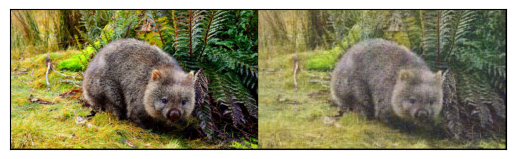

In [23]:
from torchvision.utils import make_grid

circuit.eval()

recon_image = circuit(grid_chw.to(device))
recon_image = recon_image.squeeze(dim=2).squeeze(dim=1).view(original_image.shape)
recon_image = (recon_image - recon_image.min()) / (recon_image.max() - recon_image.min())

grid_images = make_grid([original_image, recon_image], nrow=2)
plt.imshow(grid_images.permute(1, 2, 0).cpu().numpy())
plt.xticks([], []); plt.yticks([], []); plt.show()